# Implementing a Deep Belief Network in PyTorch using the FashionMNIST dataset

Implementing a Deep Belief Network in PyTorch using the FashionMNIST dataset.

Name: Alejandra Cruces

Student ID: 2078632

Date: 05/02/2024


The additional files:

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]  # With sigmoid function
  repository_url = "https://raw.githubusercontent.com/alecruces/cognition_and_computation/main/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import torch.nn.functional as functional
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

from DBN import DBN

Let's choose dynamically the kind of device used for computations (CPU or GPU).

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


I am using the FashionMNIST data set. This is a dataset from Zalando, consisting of artible images with a total of 70,000 examples divided in 60,000 examples in the training set and 10,000 images in the test set.
Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [5]:
%%capture
# Call the FasionMNIST dataset
mnist_tr = tv.datasets.FashionMNIST(root="../FashionMNIST", train=True, download=True)
mnist_te = tv.datasets.FashionMNIST(root="../FashionMNIST", train=False, download=True)

In [6]:
mnist_tr.data = mnist_tr.data / 255   # Normalized between 0 and 1
mnist_te.data = mnist_te.data / 255

In [7]:
mnist_tr.data = mnist_tr.data.to(device) # training
mnist_te.data = mnist_te.data.to(device) # test
mnist_tr.targets = mnist_tr.targets.to(device) # training labels
mnist_te.targets = mnist_te.targets.to(device) # test labels

Let's visualize one training image:

The image shows the cloth associated to the index: 0


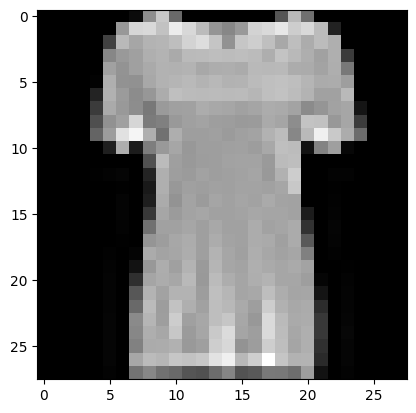

In [8]:
idx = 10
img = mnist_tr.data[idx].cpu()
print("The image shows the cloth associated to the index: {}".format(mnist_tr.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

# Training a Deep Belief Network

## Comments on the training phase
The DBN training phase used the following architecture:
- Three hidden units with 700, 800 and 1200 nodes each
- A learning rate of 0.05

These parameters were selected after testing various options, such as:

- Different learning rates (0.1, 0.09, 0.08), which did not affect the accuracy significantly
- An additional layer, which did not improve the results either
- Different numbers of nodes per layer, which had a minor impact on accuracy
To achieve a trade-off between accuracy and computational efficiency, this architecture was chosen.

In [9]:
dbn_mnist = DBN(visible_units=28*28,
                hidden_units=[700, 800, 1200], # size of hidden layers
                k=1,                          # reconstruction n° of steps in Contrastive Divergence
                learning_rate=0.05,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())


## Comments epochs and batch size:
Setting different parameters:
1. Using an initial configuration (Hidden layers, nodes, optimizer, linear read-out):
- number of epochs (50, 70, 90, 100): The accuracy does not improve after 90 epochs
- Batch size (125, 150, 200):  These settings do not affect the accuracy significantly
- The accuracy obtained with these configurations ranges from 0.82 to 0.83).
2. Changing the configuration to Adam optimizer and to Multi-layer perceptron in the linear read-out:
- Number of epochs: The accuracy increases slightly with the number of epochs, reaching the highest value at 90 epochs.
- Batch size: The accuracy is higher with a larger batch size. This may be because the FashionMNIST data set is more complex than the MNIST data set due to the higher variability in shapes and the model needs more data to generalize better and improve accuracy.

Training the model:

In [10]:
num_epochs = 90
batch_size = 200

dbn_mnist.train_static(
    mnist_tr.data,
    mnist_tr.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |3.2492     |0.1083       |270.3499   |5.6148     |
|20    |2.8012     |0.0934       |213.2125   |4.0406     |
|30    |2.6701     |0.0915       |199.2540   |3.4496     |
|40    |2.5968     |0.0890       |193.4515   |3.2573     |
|50    |2.5593     |0.0903       |192.2883   |3.4496     |
|60    |2.5328     |0.0872       |190.0944   |3.3934     |
|70    |2.5107     |0.0877       |186.8419   |3.3732     |
|80    |2.4944     |0.0885       |185.8566   |3.1543     |
|90    |2.4822     |0.0881       |184.8015   |2.9379     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6426     |0.0414       |162.9880   |3.2563     |
|20    |1.3930     |0.0321       |143.1787   |2.1708     |
|30    |1.3342     |0.0296       |137.7058   |1.9613     |
|40    |1.3074     |0.0286       |135.6763   |1.8297     |
|50    |1.2942     |0.0300       

## Visualizing receptive fields

Visualization of Receptive Field of each hidden neuron:

- Plotting weights: Analize which parts of an image trigger the unit associated with a specific weight vector

- Setting a threshold: To dimishing the noise.

- MinMaxScaler: To standarize the ranges of the weights and fairly compare the different receptive fields.

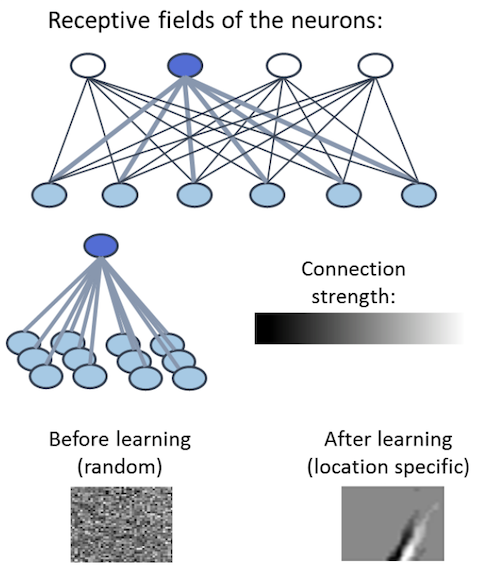

In [11]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

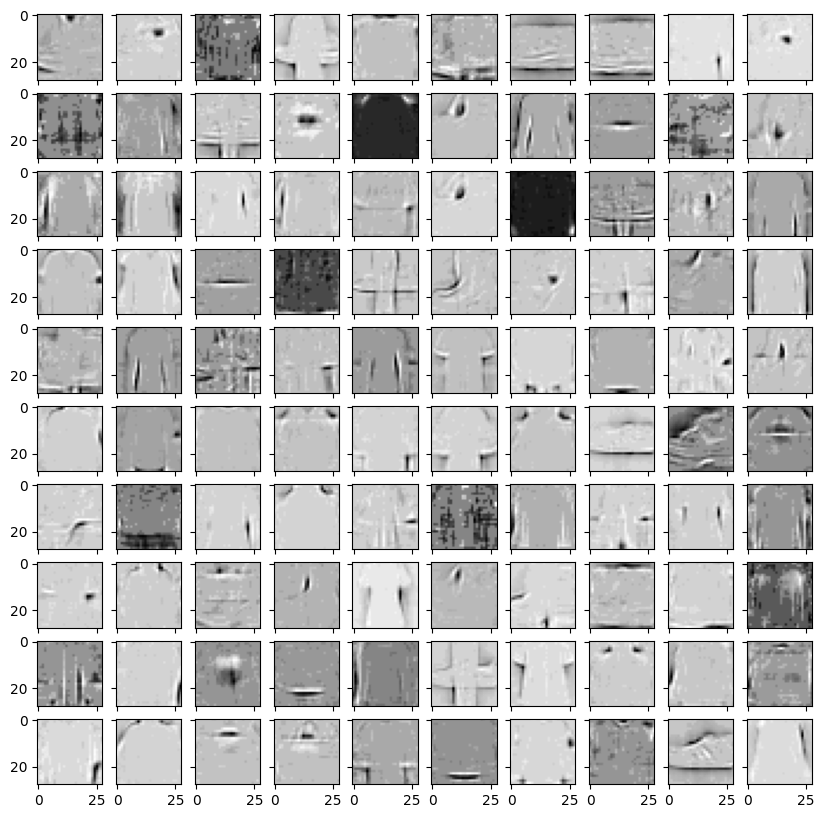

In [12]:
w1 = get_weights(dbn_mnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

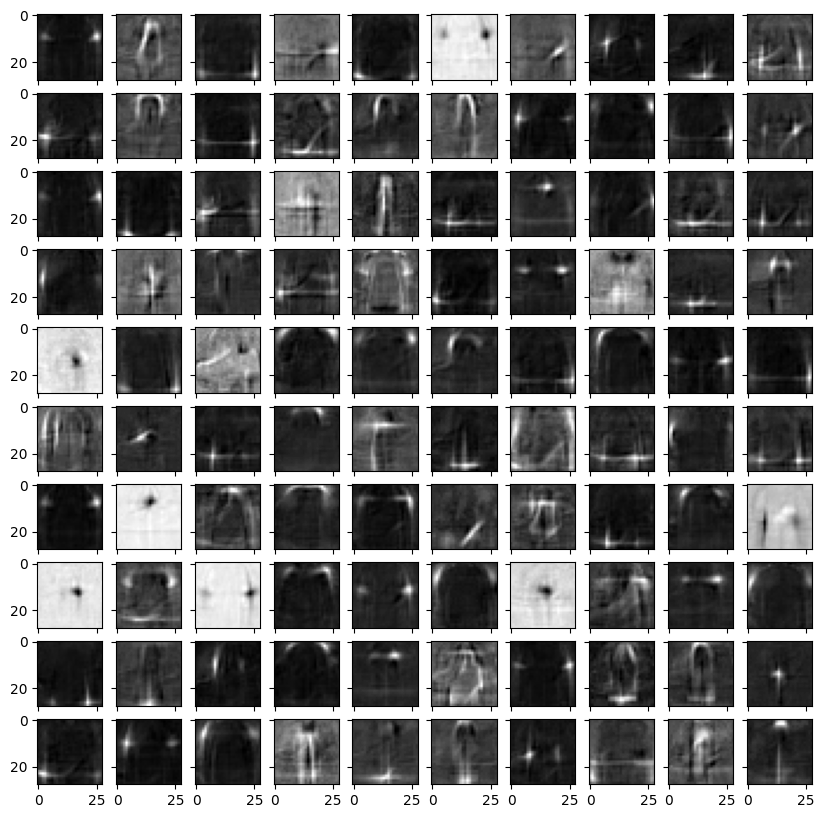

In [13]:
w1 = get_weights(dbn_mnist, layer=0)
w2 = get_weights(dbn_mnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

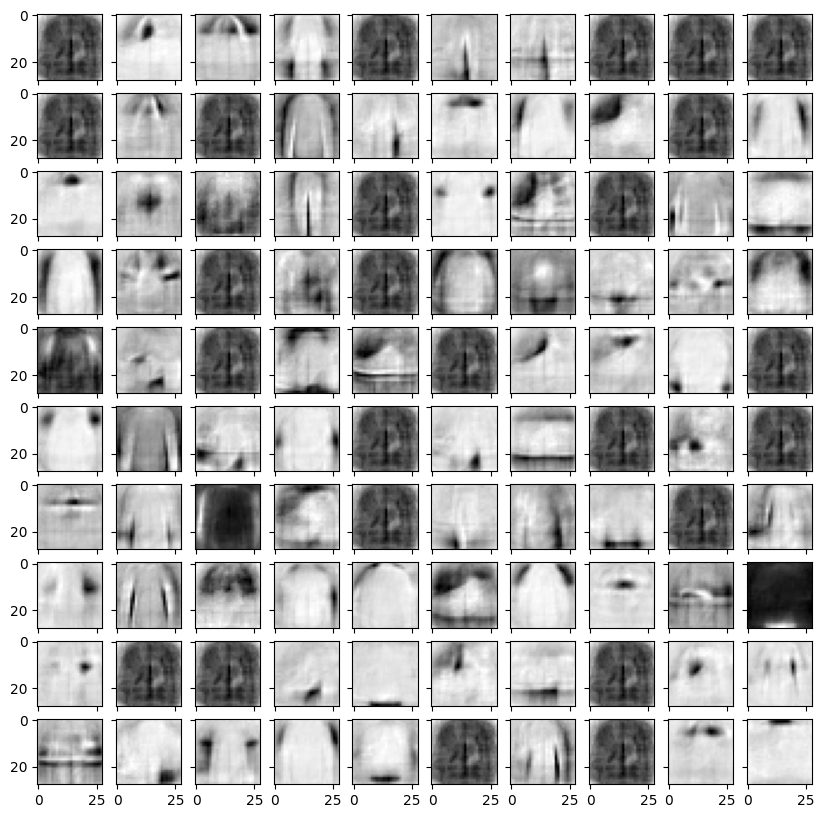

In [14]:
w1 = get_weights(dbn_mnist, layer=0)
w2 = get_weights(dbn_mnist, layer=1)
w3 = get_weights(dbn_mnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)
w_product_23 = (w_product_12 @ w3)
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

## Clustering internal representations

We can also examine the properties of the learned *distributed* representations. For example, we can compute the centroid of the representations learned for each class, and see how close they are to each other using a standard hierarchical clustering algorithm.

In [15]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [16]:
hidden_repr_1 = get_kth_layer_repr(mnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)

torch.Size([60000, 700])


In [17]:
def get_mask(label):
  labels = mnist_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
    for label in range(10)])

In [18]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

In [19]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

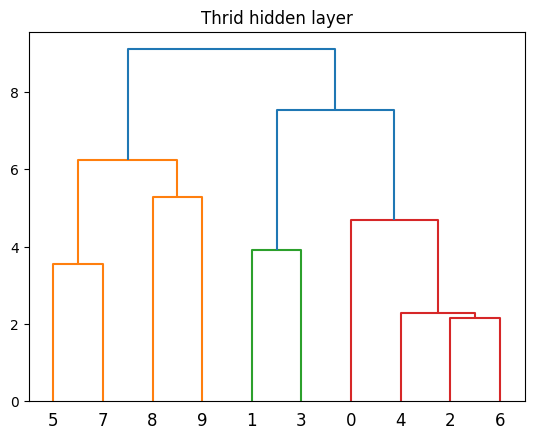

In [20]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Thrid hidden layer")

The dendogram shows a logic association if we compare the images in the same cluster: for example sandals and sneaker are together.

Images associated with each label:

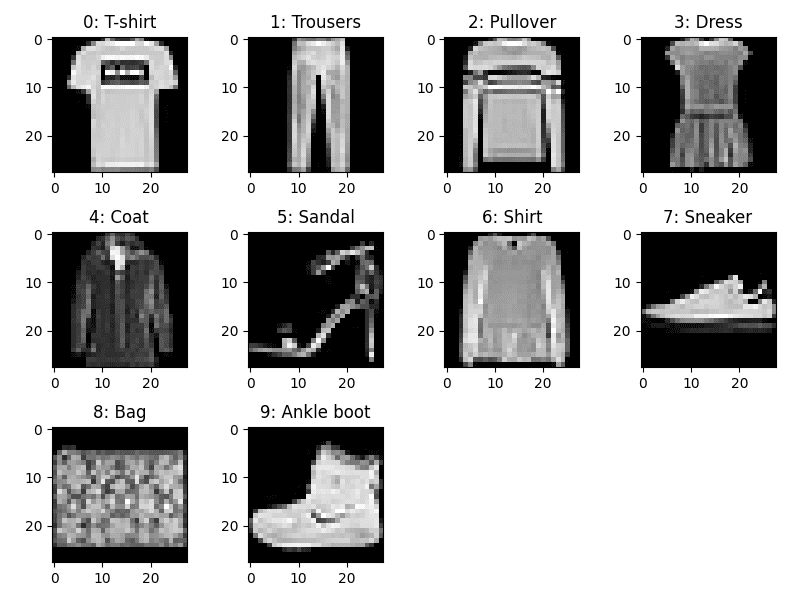

## Analyzing the internal representations developed by the model by exploiting hierarchical clustering and feature visualization (receptive fields) analysis

### Hierarchical clustering
If we analize the dendogram, we can see the following,
1. First big cluster mainly composed by shoes or accesories:

- Sandal and Sneaker
- Bag and ankle boot

2. Second big cluster mainly composed by clothes usually worn on the upper body:

- Trouser and Dress:
- T-shirt, Pullover, Coat and Shirt: Composed by clothes usually worn on the upper body. Very close in

This suggests that the DBN classifier is able to capture some semantic features of the FashionMNIST dataset, such as the type and location  (upper, lower) of the clothing items.

### Receptive field representations:

Regarding the feature visualization if the receptive field presented in the privous section,the first layer is capturing mainly the edges and lines of the input images. In the second layer, the representations looks more like shapes. While the thrid layer, the deepest one, is representing more complex visual features such as complete items clothing. This phenomen is due to the hierarchical nature of the Deep Belief Network, where at the deepest level the sensory representations become more disentagled.

Eventhough this phenomenon is clear for many of the receptive field, there are some of them that are not very clear.


## Read-out function: Supervised to perform classification

In this section I compare to read-out functions: Linear read-out and Multi-layer Perceptron.

Linear read-out

In [21]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

Multi-Layer Perceptron

In [22]:
## Multi-layer Perceptron
class MLPModel(torch.nn.Module):
    def __init__(self, layer_size, hidden_size=256):
        super(MLPModel, self).__init__()
        self.fc1 = torch.nn.Linear(layer_size, hidden_size)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [23]:
layer_size = dbn_mnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)
mlp1 = MLPModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)
mlp2 = MLPModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)
mlp3 = MLPModel(layer_size).to(device)

In [24]:
def train_supervised(network, input_data, epochs=1500):
  #optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  optimizer = torch.optim.Adam(network.parameters(), lr=0.001) #Alternative with ADAM optimizer
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = mnist_tr.targets.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

Training with the linear read-out:

In [25]:
print("First Layer")
train_supervised(linear1, hidden_repr_1, 1000)
print("Second Layer")
train_supervised(linear2, hidden_repr_2, 1000)
print("Third Layer")
train_supervised(linear3, hidden_repr_3, 1000)

First Layer
epoch :   1/1000, loss = 2.3160
epoch : 101/1000, loss = 0.6018
epoch : 201/1000, loss = 0.4761
epoch : 301/1000, loss = 0.4233
epoch : 401/1000, loss = 0.3924
epoch : 501/1000, loss = 0.3715
epoch : 601/1000, loss = 0.3561
epoch : 701/1000, loss = 0.3441
epoch : 801/1000, loss = 0.3344
epoch : 901/1000, loss = 0.3263
Second Layer
epoch :   1/1000, loss = 2.3002
epoch : 101/1000, loss = 0.5694
epoch : 201/1000, loss = 0.4635
epoch : 301/1000, loss = 0.4187
epoch : 401/1000, loss = 0.3924
epoch : 501/1000, loss = 0.3743
epoch : 601/1000, loss = 0.3608
epoch : 701/1000, loss = 0.3501
epoch : 801/1000, loss = 0.3414
epoch : 901/1000, loss = 0.3341
Third Layer
epoch :   1/1000, loss = 2.3006
epoch : 101/1000, loss = 0.5593
epoch : 201/1000, loss = 0.4539
epoch : 301/1000, loss = 0.4101
epoch : 401/1000, loss = 0.3848
epoch : 501/1000, loss = 0.3678
epoch : 601/1000, loss = 0.3553
epoch : 701/1000, loss = 0.3456
epoch : 801/1000, loss = 0.3377
epoch : 901/1000, loss = 0.3311


In [26]:
print("First Layer")
train_supervised(mlp1, hidden_repr_1, 1000)
print("Second Layer")
train_supervised(mlp2, hidden_repr_2, 1000)
print("Third Layer")
train_supervised(mlp3, hidden_repr_3, 1000)

First Layer
epoch :   1/1000, loss = 2.3025
epoch : 101/1000, loss = 0.2999
epoch : 201/1000, loss = 0.2480
epoch : 301/1000, loss = 0.2207
epoch : 401/1000, loss = 0.1951
epoch : 501/1000, loss = 0.1749
epoch : 601/1000, loss = 0.1599
epoch : 701/1000, loss = 0.1422
epoch : 801/1000, loss = 0.1291
epoch : 901/1000, loss = 0.1127
Second Layer
epoch :   1/1000, loss = 2.2986
epoch : 101/1000, loss = 0.3237
epoch : 201/1000, loss = 0.2696
epoch : 301/1000, loss = 0.2403
epoch : 401/1000, loss = 0.2210
epoch : 501/1000, loss = 0.2031
epoch : 601/1000, loss = 0.1910
epoch : 701/1000, loss = 0.1775
epoch : 801/1000, loss = 0.1679
epoch : 901/1000, loss = 0.1589
Third Layer
epoch :   1/1000, loss = 2.3021
epoch : 101/1000, loss = 0.3118
epoch : 201/1000, loss = 0.2622
epoch : 301/1000, loss = 0.2349
epoch : 401/1000, loss = 0.2181
epoch : 501/1000, loss = 0.2000
epoch : 601/1000, loss = 0.1931
epoch : 701/1000, loss = 0.1715
epoch : 801/1000, loss = 0.1715
epoch : 901/1000, loss = 0.1511


Training set evaluation

In [27]:
hidden_repr_1_test = get_kth_layer_repr(mnist_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

Predictions with the linear read-out

In [28]:
predictions_test1_linear = linear1(hidden_repr_1_test)
predictions_test2_linear = linear2(hidden_repr_2_test)
predictions_test3_linear = linear3(hidden_repr_3_test)

Predictions with the Multi-layer Percepctron

In [29]:
predictions_test1_mlp = mlp1(hidden_repr_1_test)
predictions_test2_mlp = mlp2(hidden_repr_2_test)
predictions_test3_mlp = mlp3(hidden_repr_3_test)

Accuracy and Confusion Matrix

In [30]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

def compute_confusion_matrix(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  confusion_mat = confusion_matrix(targets.cpu().numpy(), predictions_indices.cpu().numpy())

  return confusion_mat


In [31]:
print(compute_accuracy(predictions_test1_linear, mnist_te.targets))
print(compute_accuracy(predictions_test2_linear, mnist_te.targets))
print(compute_accuracy(predictions_test3_linear, mnist_te.targets))

0.8727999925613403
0.8702999949455261
0.8705999851226807


In [32]:
print(compute_accuracy(predictions_test1_mlp, mnist_te.targets))
print(compute_accuracy(predictions_test2_mlp, mnist_te.targets))
print(compute_accuracy(predictions_test3_mlp, mnist_te.targets))

0.8948999643325806
0.8952999711036682
0.8905999660491943


We can see that the Multi-layer Perceptron achieved a higher accuracy than the linear read-out. This can be explained because MLP can handle non-linear separable data and is more robust to noise.

# Confusion Matrix

As MLP performs better, we will keep this for the following analysis:

In [33]:
  confusion_matrix_first = compute_confusion_matrix(predictions_test1_mlp, mnist_te.targets)
  confusion_matrix_second = compute_confusion_matrix(predictions_test2_mlp, mnist_te.targets)
  confusion_matrix_third= compute_confusion_matrix(predictions_test3_mlp, mnist_te.targets)

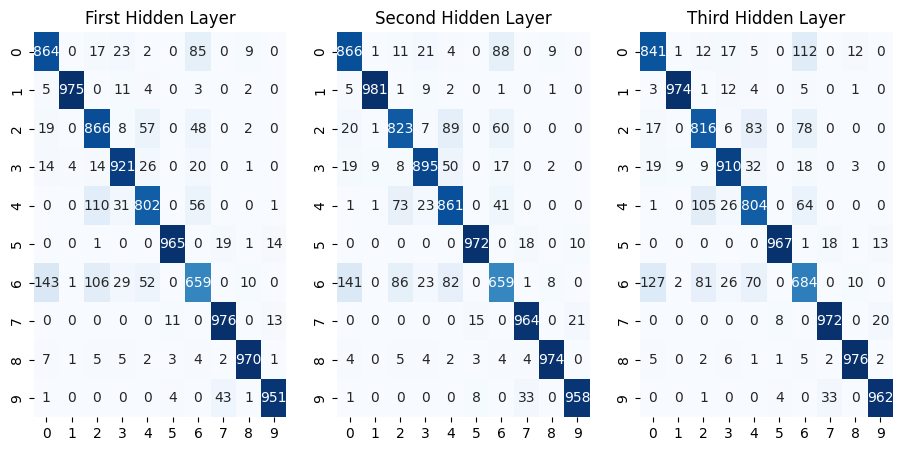

In [34]:
# Display confusion matrices
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.heatmap(confusion_matrix_first, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('First Hidden Layer')

plt.subplot(1, 4, 2)
sns.heatmap(confusion_matrix_second, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Second Hidden Layer')

plt.subplot(1, 4, 3)
sns.heatmap(confusion_matrix_third, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Third Hidden Layer')

plt.show()

## Visualize confusion matrices
By examining the confusion matrices for the three hidden layers, we can observe that labels 2 and 6 lower the classification accuracy in the deepest layer. This suggests that in the deepest layer, the distinction between clothes that are worn on the upper body becomes more challenging.


# Second Part

## Comparison with a feed-forward neural network

## Feedforward model

In [35]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size) # 784 visible neurons
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()  # Here maybe it is possible to change the activation functions, or skip connections
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [36]:
ffnn = Feedforward(700, 800, 1200).to(device)

In [37]:
train_supervised(ffnn, mnist_tr.data.reshape((60000, 784)), 1050)  # 1050 epochs (in the previous part, the DBM training included 50 + 1000 epochs in two different parts. This way we have a fair comparison)

epoch :   1/1050, loss = 2.3024
epoch : 101/1050, loss = 0.3407
epoch : 201/1050, loss = 0.2406
epoch : 301/1050, loss = 0.1814
epoch : 401/1050, loss = 0.2414
epoch : 501/1050, loss = 0.1094
epoch : 601/1050, loss = 0.0852
epoch : 701/1050, loss = 0.8805
epoch : 801/1050, loss = 0.1540
epoch : 901/1050, loss = 0.0863
epoch : 1001/1050, loss = 0.0453


In [38]:
predictions_ffnn = ffnn(mnist_te.data.reshape((10000, 784)))

In [39]:
compute_accuracy(predictions_ffnn, mnist_te.targets)

0.8930000066757202

## Robustness to noise

Injecting noise and checking robustness to perturbations in the sensory signal

In [40]:
def inject_noise(mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(mnist_data.shape, device = device) * noise_level
  return mnist_data + random_gaussian_tensor

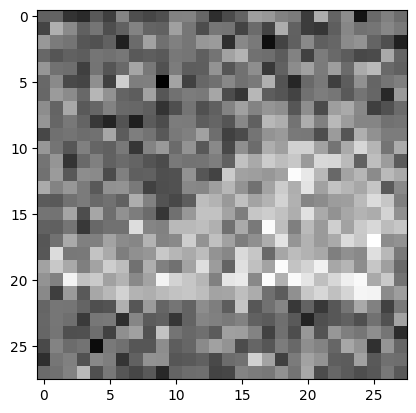

In [41]:
# print Image
noise_level = 0.3
mnist_test_with_noise = inject_noise(mnist_te.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

Hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [42]:
def compute_confusion_matrix(predictions, targets):
    predictions_indices = predictions.max(axis=1).indices
    accuracy = (predictions_indices == targets).sum() / len(targets)

    confusion_mat = confusion_matrix(targets.cpu().numpy(), predictions_indices.cpu().numpy())

    return confusion_mat

def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(mnist_te.data, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = mlp1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = mlp2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = mlp3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, mnist_te.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, mnist_te.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, mnist_te.targets)

  confusion_matrix_first_hidden = compute_confusion_matrix(predictions_first_hidden_noisy, mnist_te.targets)
  confusion_matrix_second_hidden = compute_confusion_matrix(predictions_second_hidden_noisy, mnist_te.targets)
  confusion_matrix_third_hidden = compute_confusion_matrix(predictions_third_hidden_noisy, mnist_te.targets)

  #Feed-forward model

  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.data.reshape((10000, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, mnist_te.targets)
  confusion_matrix_ffnn = compute_confusion_matrix(predictions_ffnn_noisy, mnist_te.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn, confusion_matrix_first_hidden, confusion_matrix_second_hidden, confusion_matrix_third_hidden, confusion_matrix_ffnn

In [43]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.770
Accuracy of H2 read-out: 0.849
Accuracy of H3 read-out: 0.858
Accuracy of FF network : 0.533


# Psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network:

In [44]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

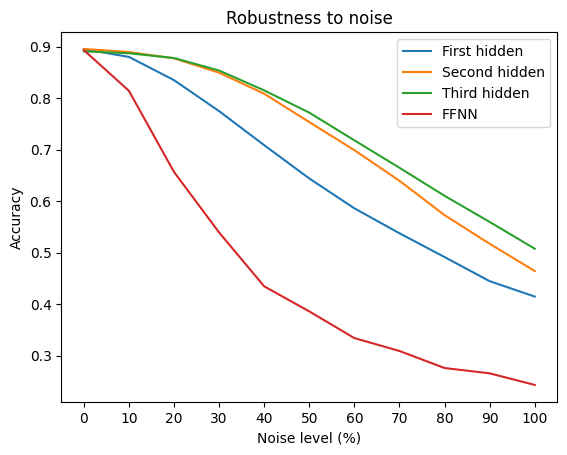

In [45]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plot_noise_robustness_curves(noise_levels)

# Confusion Matrix

Confusion Matrix original Data

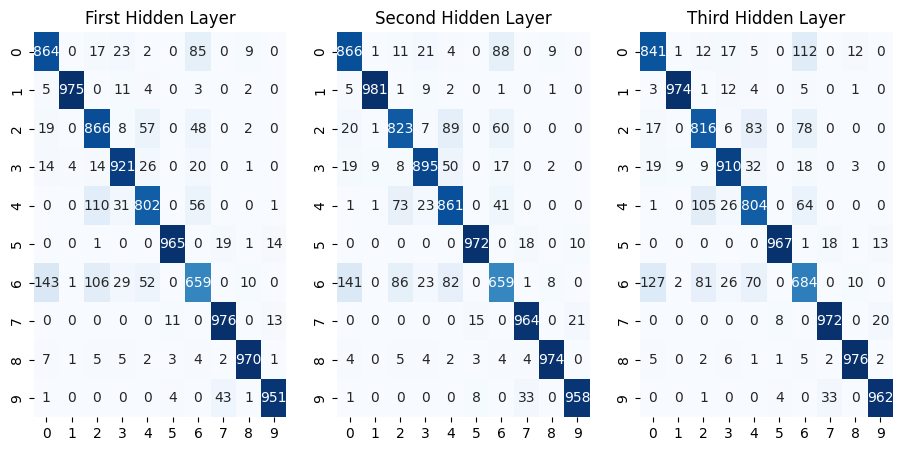

In [46]:
# Display confusion matrices
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.heatmap(confusion_matrix_first, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('First Hidden Layer')

plt.subplot(1, 4, 2)
sns.heatmap(confusion_matrix_second, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Second Hidden Layer')

plt.subplot(1, 4, 3)
sns.heatmap(confusion_matrix_third, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Third Hidden Layer')

plt.show()

Confusion Matrix Data with Noise

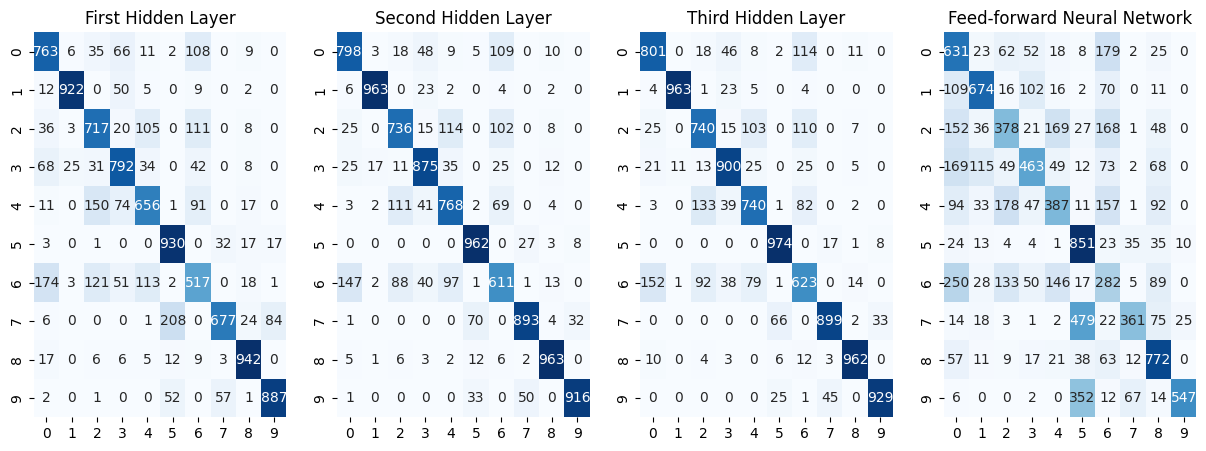

In [47]:
noise_level = 0.3
accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn, \
confusion_matrix_first_hidden, confusion_matrix_second_hidden, confusion_matrix_third_hidden, confusion_matrix_ffnn = get_accuracy_values_at_noise_level(noise_level)

# Display confusion matrices
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
sns.heatmap(confusion_matrix_first_hidden, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('First Hidden Layer')

plt.subplot(1, 4, 2)
sns.heatmap(confusion_matrix_second_hidden, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Second Hidden Layer')

plt.subplot(1, 4, 3)
sns.heatmap(confusion_matrix_third_hidden, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Third Hidden Layer')

plt.subplot(1, 4, 4)
sns.heatmap(confusion_matrix_ffnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Feed-forward Neural Network')

plt.show()

## Visualize confusion matrices and psychometric curves to investigate the kind of errors made by the model

1. Confusion Matrix Analysis:

The Confusion Matrix of the original data shows that two labels, 2 and 6, are more likely to be misclassified than others. This problem worsens when we add noise to the data. Moreover, the labels that belong to the same cluster in the dendrogram, namely 0, 2, 4 and 6, have the highest classification errors. This suggests that the semantic relation among these labels makes it harder for the algorithm to distinguish them when noise is present. As a result, the overall accuracy of the classification decreases when we add 0.3 noise to the original data.

In the case of the FFNN, the accuracy decreases drastically.

2. Psychometric curves analysis:

The psychometric curves show that the DBN can handle noise up to a certain point. The third hidden layer has the highest accuracy, which makes sense because it captures more complex relations. However, when the noise level exceeds 0.6, the accuracy drops below 70%, indicating a degradation of performance.

# Third Part

## Perturbing the models with adversarial attacks

### Fast gradient sign method

Reference: https://jaketae.github.io/study/fgsm/

In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the model's parameters, the input data and the output targets: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure:
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like (epsilon is small, in order to perturb the input just a little bit):

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

The goal here is to misclassify the input (in more advanced method, the goal could be to misclassify some class or classes)

In [48]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign() # sign of the gradient
    #Perturbed the image in the same direction as the gradient, by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    perturbed_image = torch.clamp(perturbed_image, 0, 1) # Maintaining [0,1] range

    return perturbed_image

### Adversarial samples

We need to define a unified architecture incorporating the DBN + readout layers, which allows to compute the gradient of the loss (classification task) with respect to the input data that is being processed.

In [49]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [50]:
dbn_with_readout = DBNWithReadOut(dbn_mnist, [mlp1, mlp2, mlp3], readout_level=2)
#dbn_with_readout = DBNWithReadOut(dbn_mnist, [linear1, linear2, linear3], readout_level=2)

Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

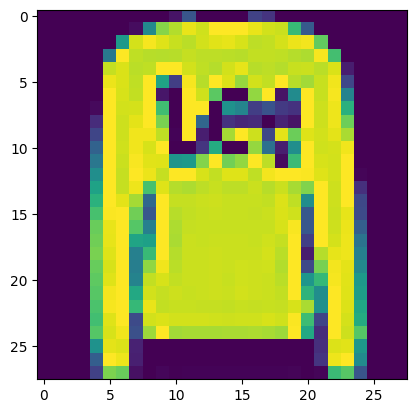

In [51]:
test_sample_idx = 1
test_image = mnist_te.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

In [52]:
attacked_model = dbn_with_readout
#attacked_model = ffnn

In [53]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 2.


Let's create and visualize the corresponding adversarial sample.
The function `loss.backward()` computes the gradient for every parameter that was activated using the call `requires_grad=True`.

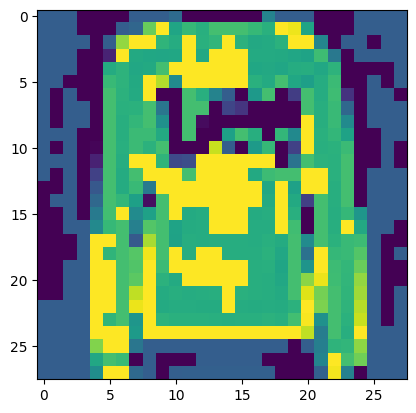

In [54]:
epsilon = 0.3
test_image_label = mnist_te.targets[test_sample_idx].unsqueeze(0)
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data

perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
perturbed_image_np = perturbed_image.detach().to("cpu").numpy()

__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [55]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 6.


### Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the DBN.

We will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [56]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    # num_steps = 0
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()

        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [57]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=True, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 10322642.98it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173965.48it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3229356.88it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20255419.32it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Let's see how good the FFNN does:

In [58]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 0.00%



Let's now compare compare with the read-out trained on the hidden representations of the DBN:

In [59]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 7.90%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



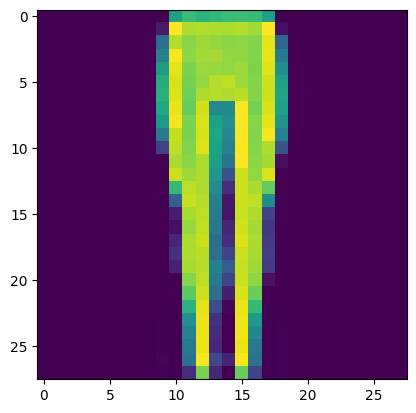


Here's a perturbed sample:



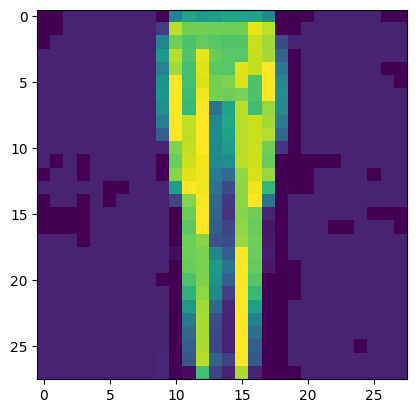


Here's what a 1-steps reconstructed sample looks like:



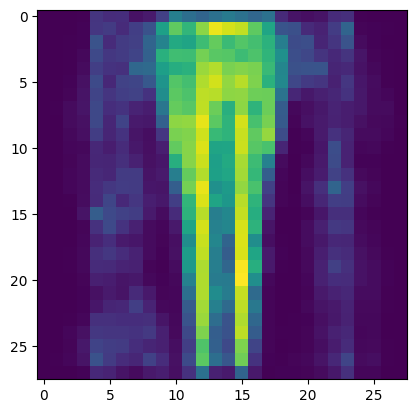


Epsilon: 0.1
Test Accuracy: 36.66%



In [60]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=1)

### Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [61]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [62]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

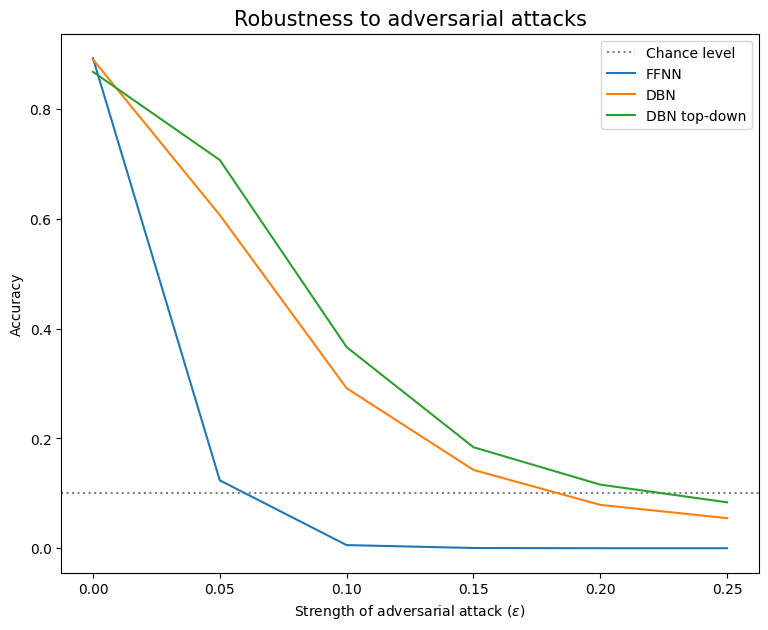

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

## Exploring the response to adversarial attacks (and potential defenses) and/or the capability of few-shot learning

Adversarial attacks aim to deceive the DBN by altering the input images from the FashionMNIST dataset. Unlike other attacks that change the model's weights, this attack changes two aspects:
- It modifies the input rather than the model's parameters;
- It follows the direction of the gradient, leading to a higher loss function.

x~=x+ϵ⋅sign(∇xJ(w,x,y))

The FNN is very sensitive to this attack, as its accuracy drops sharply with a small change in the input. The DBN is more resilient, as its accuracy decreases slowly. However, when the perturbation magnitude (epsilon) is 0.05, the DBN's accuracy falls below 50%. Adding a "top-down" reconstruction step to the DBN improves its accuracy by 10 percentage points (pp) for epsilon = 0.05 and 3pp for epsilon = 0.25.



## Conclusions and summary of the implementation (e.g., model architecture, training and testing methodology)

The following text is a summary of the comments on the training phase and the hierarchical clustering of the DBN classifier for the FashionMNIST data set:

The DBN training phase used a three-layer architecture with 700, 800 and 1200 nodes respectively and a learning rate of 0.05. These parameters were chosen after testing different options and finding a balance between accuracy, efficiency and parsimony. The accuracy did not change much with different learning rates, an extra layer or different numbers of nodes per layer. That is why I kept three hidden layers

The number of epochs and the batch size were also varied to see their effect on accuracy. Using the original configuration from the lab, the accuracy did not improve after 90 epochs and was not affected by the batch size. The accuracy ranged from 0.82 to 0.83. Changing the configuration to Adam optimizer and Multi-layer perceptron in the linear read-out, the accuracy increased slightly with the number of epochs and was higher with a larger batch size. This may be because the FashionMNIST data set is more complex than the MNIST data set and requires more data to generalize better.

The hierarchical clustering showed two main clusters: one composed by shoes or accessories (sandal, sneaker, bag and ankle boot) and another composed by clothes usually worn on the upper body (trouser, dress, t-shirt, pullover, coat and shirt). This indicates that the DBN classifier can capture some semantic features of the FashionMNIST data set.

Regarding the accuracy of the model the original data has some labels that are hard to classify, especially 2 and 6. After adding noise makes it worse, and the labels that are semantically related have more errors. The FFNN does not perform well with noise. The DBN can handle some noise, but up to certain point. The third hidden layer is the best, but it also fails when the noise is too high.

Finally, adding a "top-down" reconstruction step to the DBN we can improves its accuracy by 10 percentage points (pp) for epsilon = 0.05 and 3pp for epsilon = 0.25.
